In [56]:
import pandas as pd
from matplotlib import pyplot as plt
import yaml
import pymysql
with open('../config.yml') as f:
    config = yaml.load(f)
con = pymysql.connect(host=config['MYSQL_HOST'], user=config['MYSQL_USER'], passwd=config['MYSQL_PASSWD'], 
                      db=config['MYSQL_DB'])
project_dir = config['PROJECT']
project_db_dir = config['DATABASE']

from os import path


In [57]:
df_clinvar = pd.read_csv(path.join(project_db_dir, 'clinvar', '05_08_2019_ClinVar_RawFile.txt'), sep='\t')
df_clinvar_wo_38 = df_clinvar[df_clinvar['Assembly']=='GRCh37']

/home/kaplanlab/.local/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (18) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [58]:
df_homology = pd.read_csv('/opt/current_project/db/orthology/Homology.list', sep='\t')
df_homology = df_homology.set_index('humanGeneRefId')

In [59]:
r = []
raw_data = {'greenBars': [], 'orangeBars': []}
names = []
df_clinvar_by_gene = df_clinvar_wo_38.loc[df_clinvar_wo_38['GeneID'].drop_duplicates().index]
df_clinvar_by_gene = df_clinvar_by_gene.set_index('GeneID')
for i, species in enumerate(df_homology.columns):
    df_species = pd.concat([pd.Series(ind, str(row[species]).split(',')) for ind, row in df_homology.iterrows()]).reset_index()
    df_species.columns = [species, 'human']
    df_species = df_species[df_species[species].str.isnumeric()]
    df_species = df_species.set_index('human')
    

    
    r.append(i)
    species_genes = len(set(df_species.index.intersection(df_clinvar_by_gene.index)))
    total_genes=  len(set(df_clinvar_by_gene.index))
    raw_data['greenBars'].append(species_genes)
    raw_data['orangeBars'].append(total_genes-species_genes)
    names.append(species)

df = pd.DataFrame(raw_data)
 

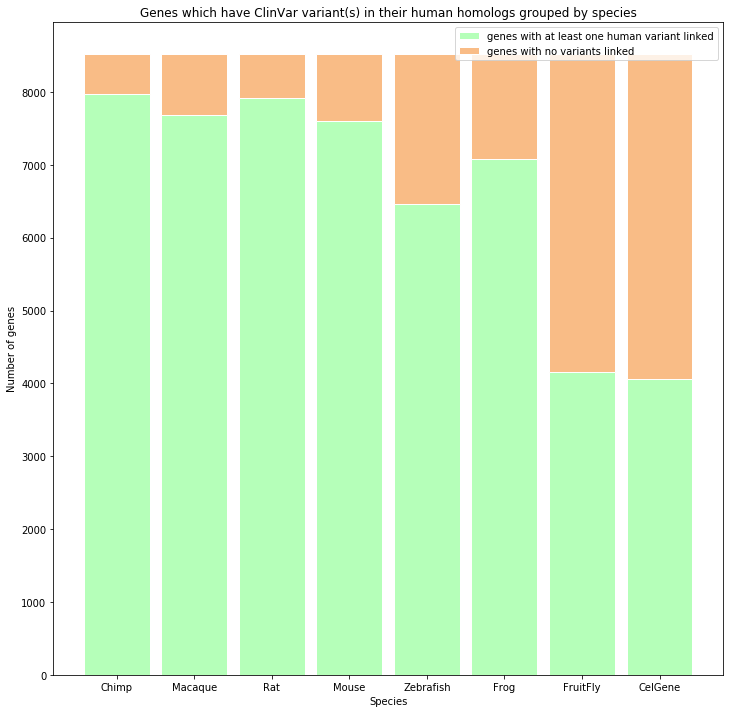

In [65]:

# From raw value to percentage
totals = [i+j for i,j in zip(df['greenBars'], df['orangeBars'])]
greenBars = [i / j * total_genes for i,j in zip(df['greenBars'], totals)]
orangeBars = [i / j * total_genes for i,j in zip(df['orangeBars'], totals)]
 
# plot
barWidth = 0.85
# Create green Bars
plt.bar(r, greenBars, color='#b5ffb9', edgecolor='white', width=barWidth)
# Create orange Bars
plt.bar(r, orangeBars, bottom=greenBars, color='#f9bc86', edgecolor='white', width=barWidth)
plt.legend(['genes with at least one human variant linked', 'genes with no variants linked'])
# Custom x axis
plt.xticks(r, [name.replace('IDs', '').replace('ID', '') for name in names])
plt.xlabel("Species")
plt.ylabel("Number of genes")
plt.title('Genes which have ClinVar variant(s) in their human homologs grouped by species')
# Show graphic
plt.savefig(path.join(project_dir, 'figures', 'homolog_genes_with_linked_clinvar_variants.png'))
plt.show()


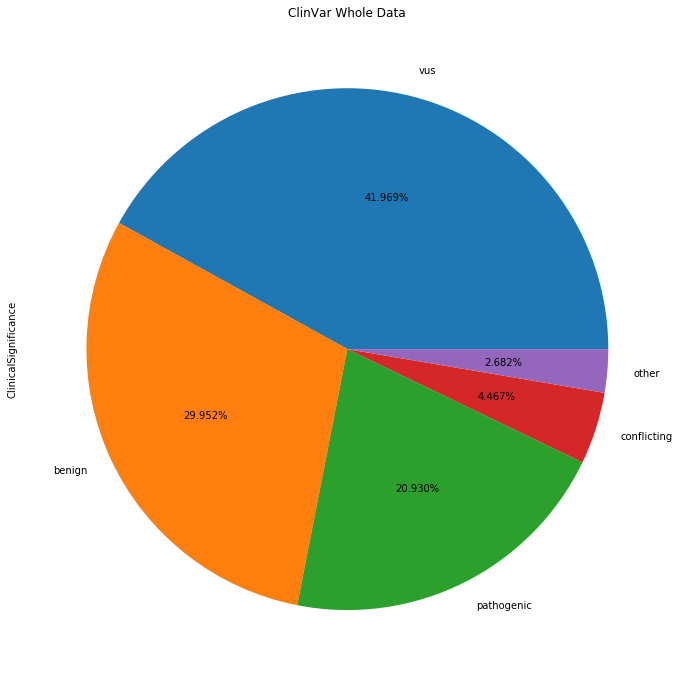

In [74]:
plt.rcParams['figure.figsize'] = [12, 12]

significance_lists = {
    'benign': ["association not found", "Benign","Benign, association","Benign/Likely benign","Benign/Likely benign, Affects","Benign/Likely benign, association",
			"Benign/Likely benign, drug response","Benign/Likely benign, drug response, risk factor","Benign/Likely benign, other","Benign/Likely benign, protective",
			"Benign/Likely benign, protective, risk factor","Benign/Likely benign, risk factor","Benign, other","Benign, risk factor","Likely benign",
			"Benign, drug response", "drug response, other", "Likely benign, drug response, other","Likely benign, other","Likely benign, risk factor", "Likely benign, other, risk factor"],
    'vus': ["Uncertain significance, association", "Uncertain significance","Uncertain significance, drug response","Uncertain significance, other","Uncertain significance, risk factor"],
    'pathogenic': ["Pathogenic","Pathogenic, Affects","Pathogenic, association, protective","Pathogenic, drug response","Pathogenic/Likely pathogenic",
"Pathogenic/Likely pathogenic, drug response","Pathogenic/Likely pathogenic, other","Pathogenic/Likely pathogenic, risk factor","Pathogenic, other",
"Pathogenic, other, risk factor","Pathogenic, protective","Pathogenic, risk factor","Likely pathogenic","Likely pathogenic, association",
"Likely pathogenic, drug response","Likely pathogenic, other","Likely pathogenic, risk factor"],
    'conflicting': ['conflicting data from submitters','Conflicting interpretations of pathogenicity','Conflicting interpretations of pathogenicity, Affects',
'Conflicting interpretations of pathogenicity, Affects, association, drug response, other','Conflicting interpretations of pathogenicity, Affects, association, risk factor',
'Conflicting interpretations of pathogenicity, Affects, other','Conflicting interpretations of pathogenicity, association','Conflicting interpretations of pathogenicity, association, other, risk factor','Conflicting interpretations of pathogenicity, drug response','Conflicting interpretations of pathogenicity, other','Conflicting interpretations of pathogenicity, other, risk factor',
'Conflicting interpretations of pathogenicity, protective','Conflicting interpretations of pathogenicity, risk factor'],
'other' :['drug response','drug response, protective, risk factor','drug response, risk factor','no interpretation for the single variant','not provided','other','Affects','Affects, association',
'Affects, risk factor','association','association, protective','association, risk factor','protective','protective, risk factor','risk factor']
}
clinical_significance_mapping = {}
for key, vals in significance_lists.items():
    for val in vals:
        clinical_significance_mapping[val] = key

significance_by_categories = df_clinvar_wo_38['ClinicalSignificance'].apply(lambda x: clinical_significance_mapping[x])

plt.title('ClinVar Whole Data')
significance_by_categories.value_counts().plot(kind='pie', autopct='%1.3f%%')

plt.savefig(path.join(project_dir, 'figures', 'pie_chart_whole_data.png'))
plt.show()

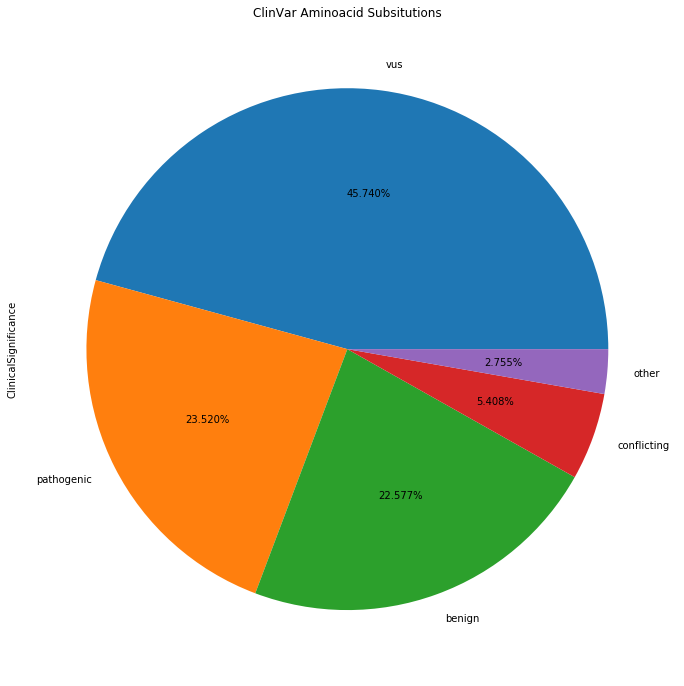

In [73]:
df_clinvar_sql = pd.read_sql('SELECT * FROM clinvar', con)
significance_by_categories = df_clinvar_sql['clinical_significance'].apply(lambda x: clinical_significance_mapping[x])

plt.title('ClinVar Aminoacid Subsitutions')
significance_by_categories.value_counts().plot(kind='pie', autopct='%1.3f%%')
plt.ylabel('ClinicalSignificance')
plt.savefig(path.join(project_dir, 'figures', 'pie_chart_aminoacid_subsitutions.png'))
plt.show()

In [67]:
df_disease = pd.read_csv('/opt/current_project/db/diseases/RawCuratedGeneDiseaseData.csv', sep='\t')
df_disease_relevant = df_disease[['geneId', 'diseaseClass']]
df_disease_relevant = pd.concat([pd.Series(row['geneId'], str(row['diseaseClass']).split(';')) for _, row in 
                                 df_disease.iterrows()]).reset_index()
df_disease_relevant.columns = ['diseaseClass', 'geneId']


In [68]:
diseases_by_gene = df_disease_relevant.groupby('geneId').apply(lambda x : ';'.join(x[x['diseaseClass']!='nan']['diseaseClass']))
diseases_by_gene = diseases_by_gene[diseases_by_gene!='']

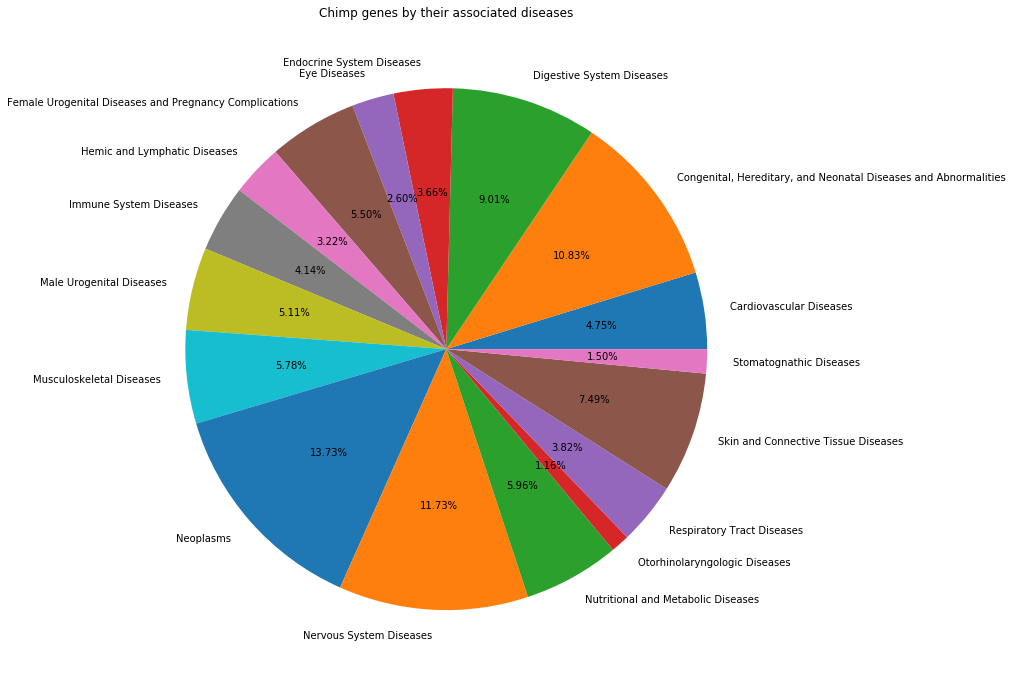

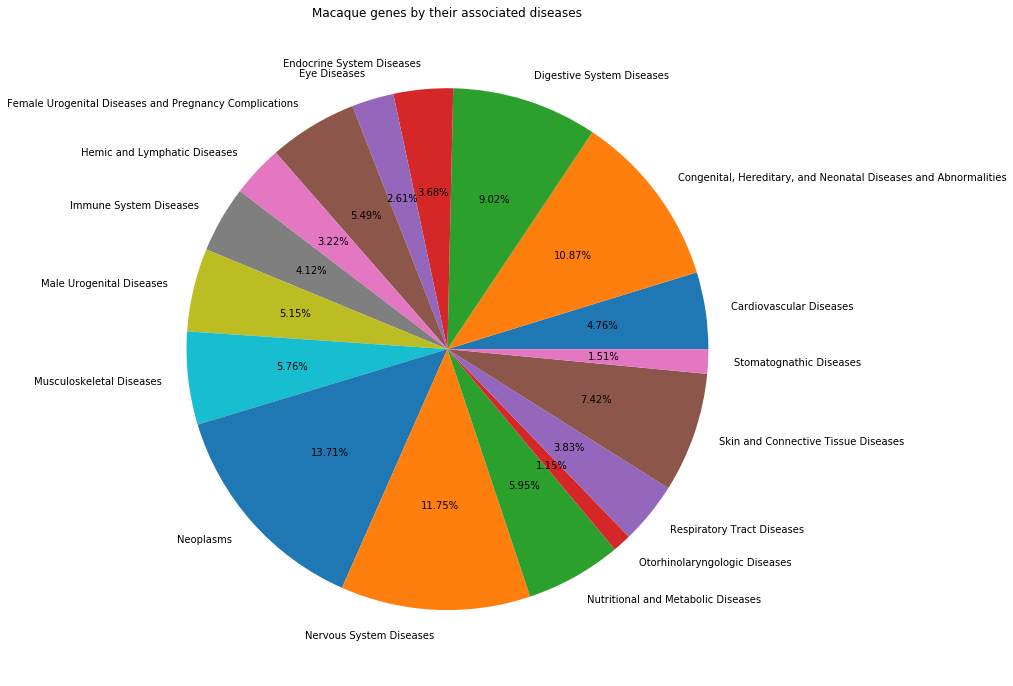

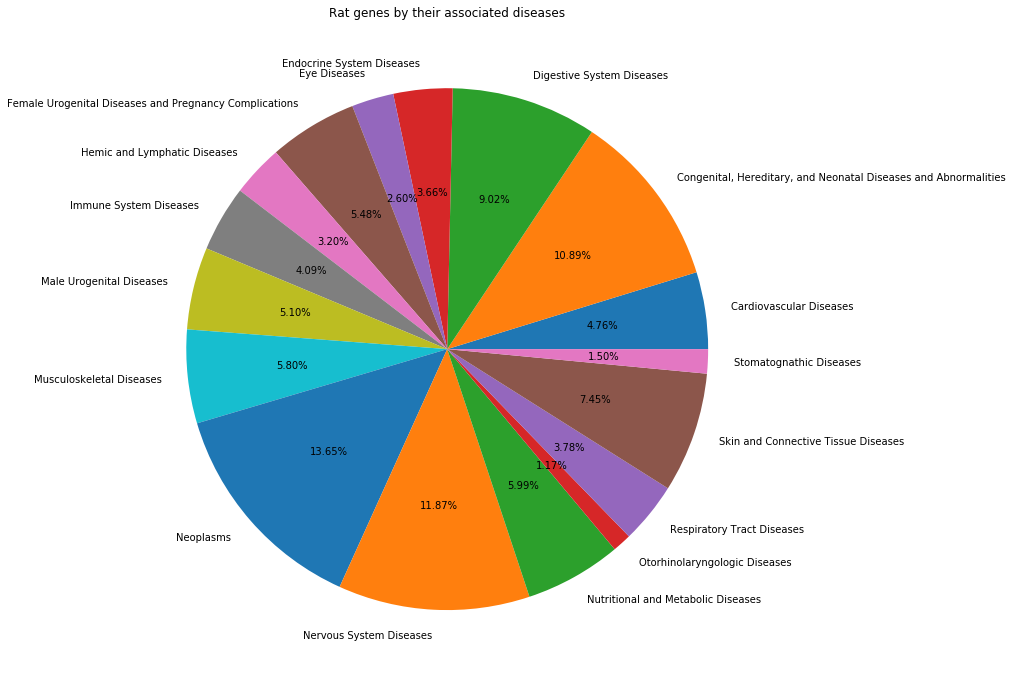

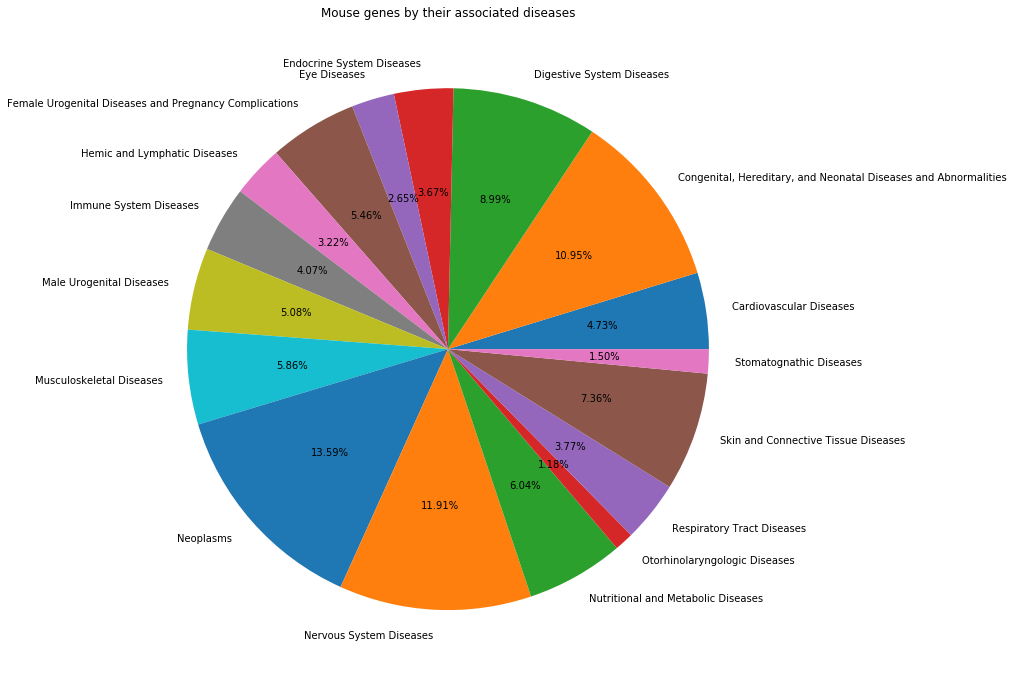

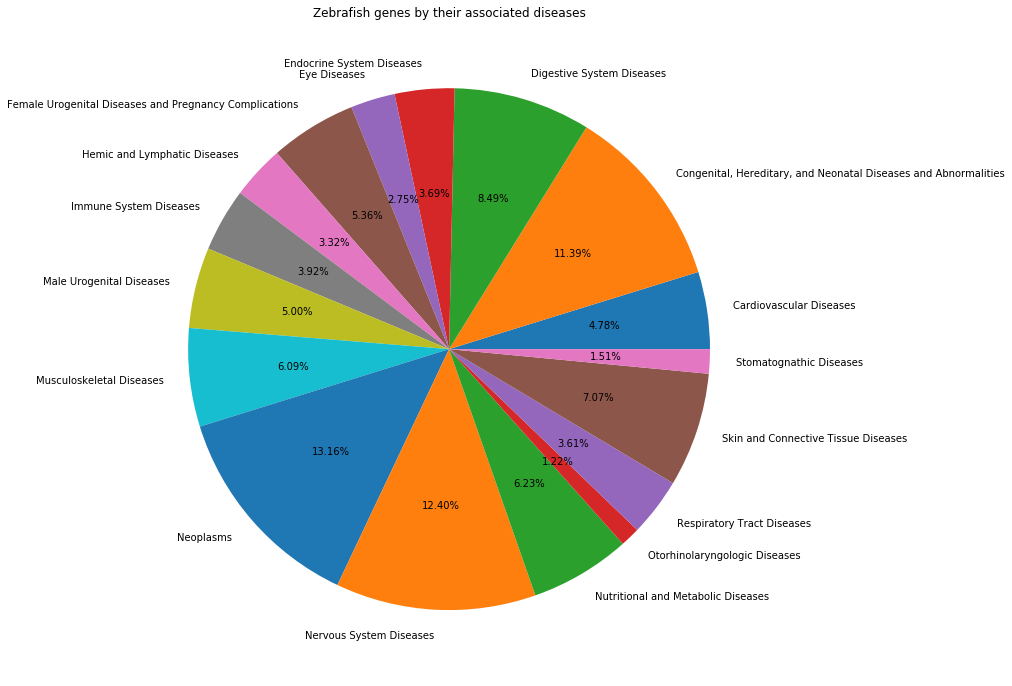

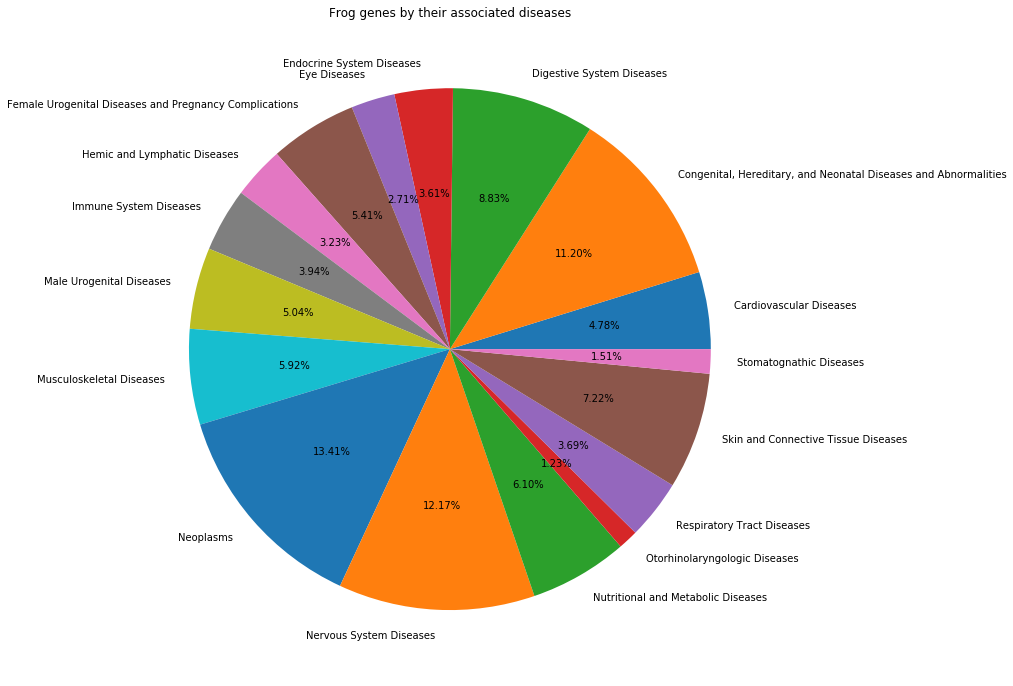

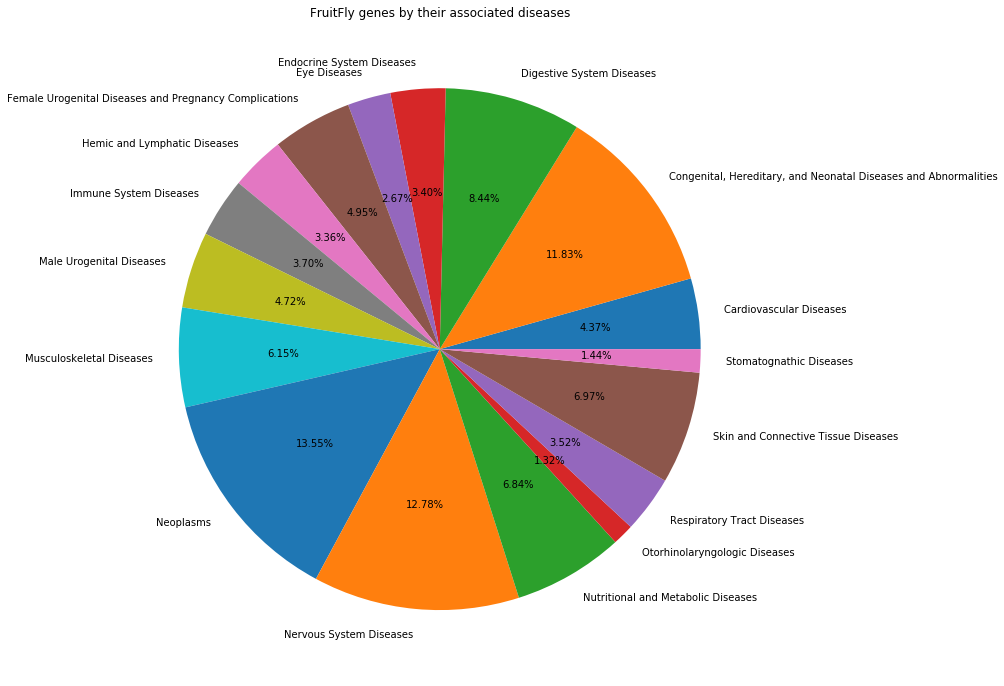

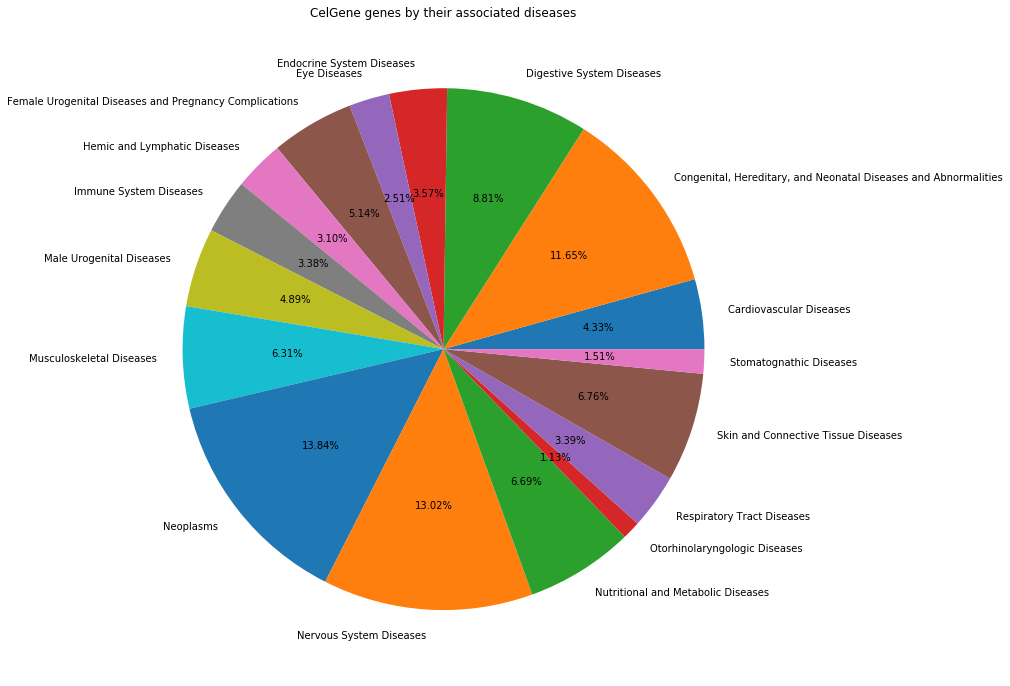

In [70]:
plt.rcParams['figure.figsize'] = [12, 12]
disease_mapping = {
    'C01': 'Bacterial Infections and Mycoses',
    'C02': 'Virus Diseases',
    'C03': 'Parasitic Diseases',
    'C04': 'Neoplasms',
    'C05': 'Musculoskeletal Diseases',
    'C06': 'Digestive System Diseases',
    'C07': 'Stomatognathic Diseases',
    'C08': 'Respiratory Tract Diseases',
    'C09': 'Otorhinolaryngologic Diseases',
    'C10': 'Nervous System Diseases',
    'C11': 'Eye Diseases',
    'C12': 'Male Urogenital Diseases',
    'C13': 'Female Urogenital Diseases and Pregnancy Complications',
    'C14': 'Cardiovascular Diseases',
    'C15': 'Hemic and Lymphatic Diseases',
    'C16': 'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
    'C17': 'Skin and Connective Tissue Diseases',
    'C18': 'Nutritional and Metabolic Diseases',
    'C19': 'Endocrine System Diseases',
    'C20': 'Immune System Diseases',
    'C21': 'Disorders of Environmental Origin',
    'C22': 'Animal Diseases',
    'C23': 'Pathological Conditions, Signs and Symptoms',
    'C24': 'Occupational Diseases',
    'C25': 'Chemically-Induced Disorders',
    'C26': 'Wounds and Injuries'
}
filtered_diseases = ['Cardiovascular Diseases',
'Congenital, Hereditary, and Neonatal Diseases and Abnormalities',
'Digestive System Diseases',
'Endocrine System Diseases',
'Eye Diseases',
'Female Urogenital Diseases and Pregnancy Complications',
'Hemic and Lymphatic Diseases',
'Immune System Diseases',
'Male Urogenital Diseases',
'Musculoskeletal Diseases',
'Neoplasms',
'Nervous System Diseases',
'Nutritional and Metabolic Diseases',
'Otorhinolaryngologic Diseases',
'Respiratory Tract Diseases',
'Skin and Connective Tissue Diseases',
'Stomatognathic Diseases']
for species in df_homology.columns:
    df_species = pd.concat([pd.Series(ind, str(row[species]).split(',')) for ind, row in df_homology.iterrows()]).reset_index()
    df_species.columns = [species, 'human']
    df_species = df_species[df_species[species].str.isnumeric()]
    df_species = df_species.loc[df_species['human'].drop_duplicates().index]
    df_species = df_species.set_index('human')
    
    df_species.loc[diseases_by_gene.index.intersection(df_species.index), 'diseases'] = diseases_by_gene
    df_species = df_species[~df_species['diseases'].isna()]
    df_species_diseases = pd.concat([pd.Series(ind, str(row['diseases']).split(';')) for ind, row in 
                                 df_species.iterrows()]).reset_index()
    df_species_diseases = df_species_diseases.drop_duplicates()
    
    df_species_diseases.columns = ['disease', 'geneId']
    species_name = species.replace('IDs', '').replace('ID', '')
    plt.title(species_name + " genes by their associated diseases")
    
    df_species_diseases['disease'].value_counts().rename(disease_mapping).filter(filtered_diseases)\
             .plot(kind='pie', autopct='%1.2f%%')
    plt.ylabel(None)
    plt.xticks(rotation=35)
    plt.savefig(path.join(project_dir, 'figures', species_name+'genes_by_associated_diseases.png'))
    plt.show()
    